# Tutorial 2. A Simple Toy Regression

This is a quick example showing how one can use the concepts introduced in [Tutorial 1: Basics](https://caffe2.ai/docs/tutorial-basics-of-caffe2.html) to do regression. This tutorial is split up into two parts. **Part I** is a more verbose example of creating and training a polynomial regression model and **Part II** is a concise linear regression example.

## Part I: Polynomial Regression

The problem we are dealing with is a relatively simple one and involves a one-dimensional input $x$ and one-dimensional output $y.$ Because we seek a second order polynomial as the regression model, the weight vector will contain two weights ($\beta_2$ and $\beta_1$) and there will be a single bias ($\beta_0$) or intercept. The desired solution is of the form:

$$y = \beta_2x^2 + \beta_1x + \beta_0$$

For this tutorial, we will generate and format an arbitrary set of input data that possess a strong second order polynomial relationship. We will then construct the model, specify the training algorithm, perform the training, and finally look at the results.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
from caffe2.python import workspace, brew, optimizer
from caffe2.python.model_helper import ModelHelper
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn.preprocessing import PolynomialFeatures

### Inputs

Specify the input parameters of the regression model here including: number of samples in the input data, number of training iterations, learning rate of SGD algorithm, and the initial weights of the model

In [2]:
# Number of training sample to generate
num_samples = 200
# Learning Rate of SGD algorithm
learning_rate = .05
# Number of iterations to train
training_iters = 100
# Initial model weights
initial_weights = [0.,0.]

### Create and Prepare the Dataset

Now, we will create and prepare the dataset for use with the model. Note, we are just constructing numpy arrays here. Any other data can be used as long as it is shaped properly before being input into the model.

X Sample:
[[ 1.11144622  1.2353127 ]
 [-0.80563214  0.64904315]
 [-0.20122346  0.04049088]
 [-1.39473823  1.94529472]
 [-0.26264545  0.06898263]]
Y Sample:
[[2.0341036 ]
 [1.25892588]
 [0.54689346]
 [2.488389  ]
 [1.00825533]]


Text(0.5,1,u'Input Training Data')

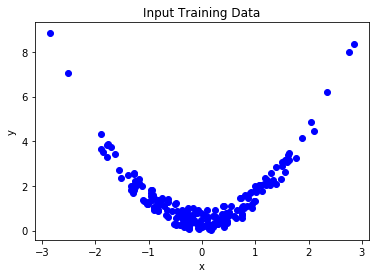

In [3]:
# Create the original observations
orig_X,_ = sklearn.datasets.make_regression(n_samples=num_samples,n_features=1,noise=5)
poly = PolynomialFeatures(degree=2, include_bias=False)
# Transform the features into second order polynomial features
xx_ = poly.fit_transform(orig_X)

# Extract the predictors and the values from the manufactured data
X = [i[0] for i in xx_]
Y_gt = [i[1] for i in xx_]
noise = np.random.uniform(size=(len(Y_gt)))
# Add some noise to the ground truth values
Y_gt += noise

# Shape the ground truth values for use with the model
Y_gt = np.reshape(Y_gt,(-1,1))
# Format the input features. Recall, we accomplish polynomial regression by
#   including the original and the polynomial version of the predictors
#   as features of the model
X = np.hstack((np.array(X).reshape(-1,1),np.array(X).reshape(-1,1)**2))

# Print a sample of the input data. X is the list of 2-feature input observations 
#   and Y is the list of ground truth values associated with each observation
print("X Sample:\n{}".format(X[:5]))
print("Y Sample:\n{}".format(Y_gt[:5]))

# Plot the input data
plt.scatter([i[0] for i in X],Y_gt,label="original data",color='b')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Input Training Data")

### Create the Model

#### Define the model architecture
With our training data created and our second order polynomial assumption stated, we can now create a model to learn the regression line. We will use a 'FC' layer as the main component of the model. Since we desire two weights ($\beta_2$ and $\beta_1$), we set our input dimension to 2, and since we only expect a single quantitative result, our output dimension is 1. Note, when using an 'FC' layer it is implied that there is a bias, which we will use as our $\beta_0.$

Also, before continuing take a look at the protobuf created in this step. The first print out is of the 'net,' and contains the architecture of the model. At a glance, we see that as expected, there is a single op in the network that expects an input $X,$ a weight and bias, and outputs $y_{pred}.$ In the print out of the 'param_init_net,' we see that this is where the initializations for the weights and biases exist. This is an important observation that gives insight into how a model in Caffe2 is constructed and maintained.

In [4]:
# Create the model helper object we will use to create the regression model
regression_model = ModelHelper(name="regression_model")

# Add the FC layer, which is the main component of a linear regression model
y_pred = brew.fc(regression_model,'X','y_pred', dim_in=2, dim_out=1)

# Print the predict and init net to see what protobuf was created for this model
print("************* Predict Net *************")
print(regression_model.net.Proto())
print("\n************* Init Net *************")
print(regression_model.param_init_net.Proto())

************* Predict Net *************
name: "regression_model"
op {
  input: "X"
  input: "y_pred_w"
  input: "y_pred_b"
  output: "y_pred"
  name: ""
  type: "FC"
  arg {
    name: "use_cudnn"
    i: 1
  }
  arg {
    name: "order"
    s: "NCHW"
  }
  arg {
    name: "cudnn_exhaustive_search"
    i: 0
  }
}
external_input: "X"
external_input: "y_pred_w"
external_input: "y_pred_b"


************* Init Net *************
name: "regression_model_init"
op {
  output: "y_pred_w"
  name: ""
  type: "XavierFill"
  arg {
    name: "shape"
    ints: 1
    ints: 2
  }
}
op {
  output: "y_pred_b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 1
  }
}



#### Add the training operators and prime the workspace

In this **very important** step, we specify the loss function, setup the SGD training algorithm, prime and initialize the workspace, and initialize our model's weights and biases.

In [5]:
# The loss function is computed by a squared L2 distance, 
#   and then averaged over all items.
dist = regression_model.SquaredL2Distance(['Y_gt', y_pred], "dist")
loss = regression_model.AveragedLoss(dist, "loss")

# Add the gradient operators and setup the SGD algorithm
regression_model.AddGradientOperators([loss])
optimizer.build_sgd(regression_model, base_learning_rate=learning_rate)

# Prime the workspace with some data
workspace.FeedBlob("Y_gt",Y_gt.astype(np.float32))
workspace.FeedBlob("X",X.astype(np.float32))

# Run the init net to prepare the workspace then create the net
workspace.RunNetOnce(regression_model.param_init_net)
workspace.CreateNet(regression_model.net)

# Inject our desired initial weights and bias
workspace.FeedBlob("y_pred_w",np.array([initial_weights]).astype(np.float32))
workspace.FeedBlob("y_pred_b",np.array([0.]).astype(np.float32))

True

#### Run the training

In [6]:
# Run the training for training_iters
for i in range(training_iters):
    workspace.RunNet(regression_model.net)

print("Training Complete")

Training Complete


### Extract Results

Now that our model is trained, we can pull out the learned weights and biases which exist as blobs in the workspace named 'y_pred_w' and 'y_pred_b.'

Best Fit Line: 1.0157*x^2 + 0.01501*x + 0.4665


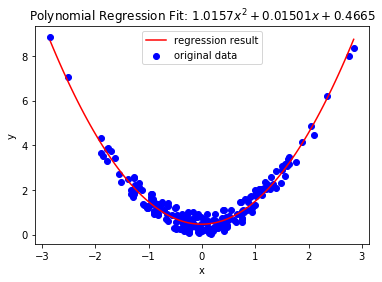

In [7]:
# Extract the learned coes and intercept from the workspace
coes = workspace.FetchBlob("y_pred_w")[0]
intercept = workspace.FetchBlob("y_pred_b")

# Calculate the regression line for plotting
x_vals = np.linspace(orig_X.min(), orig_X.max(),100)
regression_result = intercept[0] + coes[0]*x_vals + coes[1]*(x_vals**2)
print("Best Fit Line: {}*x^2 + {}*x + {}".format(round(coes[1],5), round(coes[0],5), round(intercept[0],5)))

# Plot the results of the regression
plt.scatter([i[0] for i in X],Y_gt,label="original data",color='b')
plt.plot(x_vals,regression_result,label="regression result",color='r')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Polynomial Regression Fit: ${{{}}}x^2 + {{{}}}x + {{{}}}$".format(round(coes[1],5), round(coes[0],5), round(intercept[0],5)))
plt.show()


## Part II: Express Linear Regression Example

The above example shows you how to create a polynomial regression model that is easily adapted to handle higher order polynomials. Now, we will consider the baseline case where we desire a simple first order model, with 1-D input $x,$ 1-D output $y,$ and a solution of the form:

$$y = \beta_1x + \beta_0$$

The structure of Part II will be similar to Part I. First, we will generate the dataset, then we will construct the model and specify the training routine, and finally we will train and extract our results.

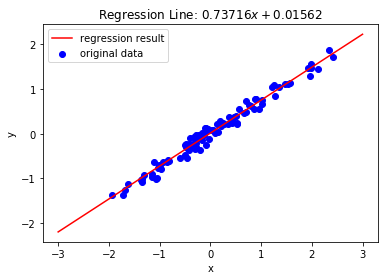

In [8]:
#####################################################################
# Initialize data
#####################################################################
X,Y_gt = sklearn.datasets.make_regression(n_samples=100,n_features=1,noise=10)
Y_gt = np.reshape(Y_gt,(-1,1))
Y_gt /= 100.

#####################################################################
# Create and train model
#####################################################################
# Construct model with single FC layer
regression_model = ModelHelper(name="regression_model")
y_pred = brew.fc(regression_model,'X','y_pred', dim_in=1, dim_out=1)

# Specify Loss function
dist = regression_model.SquaredL2Distance(['Y_gt', y_pred], "dist")
loss = regression_model.AveragedLoss(dist, "loss")

# Get gradients for all the computations above.
regression_model.AddGradientOperators([loss])
optimizer.build_sgd(regression_model, base_learning_rate=0.05)

# Prime and prepare workspace for training
workspace.FeedBlob("Y_gt",Y_gt.astype(np.float32))
workspace.FeedBlob("X",X.astype(np.float32))
workspace.RunNetOnce(regression_model.param_init_net)
workspace.CreateNet(regression_model.net)

# Set the initial weight and bias to 0
workspace.FeedBlob("y_pred_w",np.array([[0.]]).astype(np.float32))
workspace.FeedBlob("y_pred_b",np.array([0.]).astype(np.float32))

# Train the model
for i in range(100):
    workspace.RunNet(regression_model.net)

#####################################################################
# Collect and format results
#####################################################################
# Grab the learned weight and bias from workspace
coe = workspace.FetchBlob("y_pred_w")[0]
intercept = workspace.FetchBlob("y_pred_b")

# Calculate the regression line for plotting
x_vals = range(-3,4)
regression_result = x_vals*coe + intercept

# Plot the results
plt.scatter(X,Y_gt,label="original data",color='b')
plt.plot(x_vals,regression_result,label="regression result",color='r')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regression Line: ${{{}}}x + {{{}}}$".format(round(coe,5), round(intercept[0],5)))
plt.show()
